# Multivariate time series prediction using MLP in Keras 

Borrowed from [here](https://machinelearningmastery.com/how-to-develop-multilayer-perceptron-models-for-time-series-forecasting/).

## One step predictions

### Univariate

As input we have a sequence of data: `[10, 20, 30, 40, 50, ...]`.

Technically, the model will view each time step as a separate feature instead of separate time steps.

We almost always have multiple samples, therefore, the model will expect the input component of training data to have the dimensions or shape:

`[samples, features]` e.g.:  
```
X = [[10, 20, 30],
     [20, 30, 40], 
     
     [30, 40, 50],
     ...]
```  
and the output:
```
y = [40,
     50,
     60,
     ...]
```

### Multivariate (one output)

In this case, we have many parallel time series where each of them is traditionally represented as column:

```
[[ 10  15  25],
 [ 20  25  45],
 [ 30  35  65],
 [ 40  45  85],
 ...]
 ```
 
 Our transformed input/output for one sample will look like:
 
```
X[0] = [[10, 15],
       [20, 25],
       [30, 35]]
```  
```
y[0] = 65
```

Note that the choice of the input sequence length has an impact on how many outputs will be taken into account!

In general, our input is of shape `[time_series, samples, features]`. Therefore we have two possibilities:

1. in order to feed it into a single MLP, we need to concatenate the last two dimensions: `X[0] = [10, 15, 20, 25, 30, 35]`:
    ```python
    n_input = X.shape[1] * X.shape[2]
    X = X.reshape((X.shape[0], n_input))
    model = Sequential()
    model.add(Dense(100, activation='relu', input_dim=n_input))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    ```
2. Alternatively, we can create so-called multi-headed MLP using Keras functional API. 
    - Each input series can be handled by a separate MLP.
    - The output of each of these submodels can be combined before a prediction is made for the output sequence.
    ```python
    # separate input data
    n_steps = X.shape[1]
    X1 = X[:, :, 0]
    X2 = X[:, :, 1]
    # first input model
    visible1 = Input(shape=(n_steps,))
    dense1 = Dense(100, activation='relu')(visible1)
    # second input model
    visible2 = Input(shape=(n_steps,))
    dense2 = Dense(100, activation='relu')(visible2)
    # merge input models
    merge = concatenate([dense1, dense2])
    output = Dense(1)(merge)
    model = Model(inputs=[visible1, visible2], outputs=output)
    model.compile(optimizer='adam', loss='mse')
    # fit model
    model.fit([X1, X2], y, epochs=2000, verbose=0)
    ```
    
### Multivariate (many outputs)

An alternate time series problem is the case where there are multiple parallel time series and a value must be predicted for each. Let's use the same dataset:
```
[[ 10  15  25],
 [ 20  25  45],
 [ 30  35  65],
 [ 40  45  85],
 [ 50  55  105],
 ...]
```
Then:  
```
X[0] = [[10, 15, 25],
       [20, 25, 45],
       [30, 35, 65]]
y[0] = [40, 45, 85]
```
```
X[1] = [[20, 25, 45],
       [30, 35, 65],
       [40 45 85]]
y[1] = [50, 55, 105]
...
```
We can use the two above options with little changes:
   
1. Replace `model.add(Dense(1))` with `model.add(Dense(Y.shape[1))`
2. A few modifications are required:
    - add another layers `X3`, `visible3` and `Dense3` and change the code accordingly
    - replace `output = Dense(1)(merge)` with `output = Dense(Y.shape[1))(merge)`
    
Or:    

3. Multi-output MLP model:
    ```python
    # flatten input
    n_input = X.shape[1] * X.shape[2]
    X = X.reshape((X.shape[0], n_input))
    # separate output
    y1 = y[:, 0].reshape((y.shape[0], 1))
    y2 = y[:, 1].reshape((y.shape[0], 1))
    y3 = y[:, 2].reshape((y.shape[0], 1))
    # define model
    visible = Input(shape=(n_input,))
    dense = Dense(100, activation='relu')(visible)
    # define output 1
    output1 = Dense(1)(dense)
    # define output 2
    output2 = Dense(1)(dense)
    # define output 3
    output3 = Dense(1)(dense)
    # tie together
    model = Model(inputs=visible, outputs=[output1, output2, output3])
    model.compile(optimizer='adam', loss='mse')
    ```
4. Multi-headed multi-output MLP 
    - combination of 2. and 3.
   
Note that:
- both 1. and 3. require concatenation of the input series
- in 3. the model outputs three distinct values for every series
- in 2. we treat the input series as independent, add dependency later and predict one output with three values  
- in 4. we treat the input series as independent and outputs three distinct values

## Multi-Step predictions

Predict more than one step ahead.

### Univariate

As above but we need to change `y` e.g.

For `[samples, features]` of the form:  
```
X = [[10, 20, 30],
     [20, 30, 40],
     [30, 40, 50],
     ...]
```  
we need:
```
y = [40, 50,
     50, 60,
     60, 70,
     ...]
```

The output layer shall be modified accordingly to return two (or more) values instead of just one.

### Multivariate (one output)

Again, for `X` of the form:

```
[[ 10  15  25],
 [ 20  25  45],
 [ 30  35  65],
 [ 40  45  85],
 [ 50, 55, 105],
 ...]
 ```
 
We require:
 
```
X[0] = [[10, 15],
       [20, 25],
       [30, 35]]
```  
```
y[0] = [65, 85]
```

The output layer shall be modified accordingly to return two (or more) values instead of just one.


### Multivariate (many outputs)

For `X` as above:

```
X[0] = [[10, 15, 25],
       [20, 25, 45],
       [30, 35, 65]]
       
y[0] = [[40, 45, 85]
       [50, 55, 105]]
...
```

- For options 1. and 2. the output layer shall be modified accordingly to return `2 * n_features` (or more) values instead of just one (i.e. in the concatenated form). 
- For options 3. and 4. the model shall predict 2 (or more) values separately from each output layer.


In [1]:
import os
import sys
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

In [2]:
MODULE_PATH = os.path.abspath('/storage/pszczerbiak/microbiome_interactions_project/')  # TODO load from CONFIG file
if MODULE_PATH not in sys.path:
    sys.path.append(MODULE_PATH)

In [3]:
from utils.transformers import CLRTransformer, Log1pMinMaxScaler, IdentityScaler
from utils.train_test import series_to_supervised, split_reframed, prepare_sequential_data, prepare_supervised_data
from models.baseline import naive_predictor, sequential_mlp, supervised_mlp, SupervisedMLP, SequentialMLP
from models.baseline_with_diff import SupervisedDiffMLP, SequentialDiffMLP
from utils.evaluate import calculate_measures, plot_series

## Load data

In [4]:
dname = 'donorA'  # dataset name
ref_dname = 'donorB'  # reference (test) dataset name
sname = 'clr_0_True' # scaler name e.g. 'id', 'clr_None_True', 'log1pminmax'

DATA_PATH = Path("/storage/zkarwowska/microbiome-interactions/datasets/processed/ready_datasets_transformed/common")  # TODO load from CONFIG file
dataset = pd.read_csv(DATA_PATH / f"{dname}_{sname}.csv", index_col=0)
dataset_original = pd.read_csv(DATA_PATH / f"{dname}.csv", index_col=0)
ref_dataset_original = pd.read_csv(DATA_PATH / f"{ref_dname}.csv", index_col=0)
scaler = joblib.load(DATA_PATH / f'scaler_{dname}_{sname}.obj')

#### Additional parameters for `scaler.inverse_transorm()`

For `clr` transformations we don't want to remove pseudocounts since it requires knowledge where initial 0's are located (there are not always known)

In [5]:
sparams = {'remove_pseudocounts': False} if sname.startswith('clr') else {}

#### Reference dataset may have different number of rows but the same number of columns

In [6]:
dataset.shape, dataset_original.shape, ref_dataset_original.shape

((365, 166), (365, 166), (253, 166))

In [7]:
assert dataset.shape == dataset_original.shape
assert dataset.shape[1] == ref_dataset_original.shape[1]

#### Differencing (demo #1)

In [8]:
# diff = dataset.diff().iloc[1:]
# diff_reverse = pd.concat([dataset.iloc[0,:].to_frame().T, diff]).cumsum()
# # diff_reverse.equals(dataset)  # doesn't work: 0 against 1e-16
# assert np.allclose(dataset, diff_reverse)
# assert (dataset.index == diff_reverse.index).all()
# assert (dataset.columns == diff_reverse.columns).all()

## Plot data

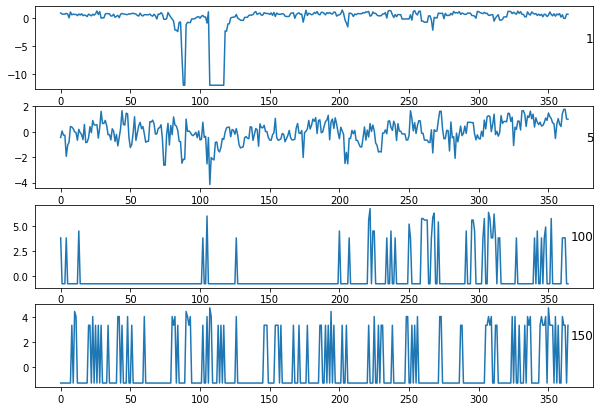

In [9]:
columns = [1, 5, 100, 150]
plt.figure(figsize=(10, 7))
for i, column in enumerate(columns):
    plt.subplot(len(columns), 1, i+1)
    plt.plot(dataset.iloc[:, column])
    # plt.plot(dataset_original.iloc[:, column])
    plt.title(column, y=0.5, loc='right')
plt.show()

## Data Preparation

The first step is to prepare the dataset for ML predictions. This involves framing the dataset as a supervised learning problem and normalizing the input variables (already done above).

### Convert series to supervised learning

**Assumption**  
We believe that predicitions in subsequent time step depend on values from **the last `STEPS_IN` time steps only**. 

Therefore:  

Number of samples = `dataset.shape[0] // STEPS_IN` (we need to throw last couple of timesteps)  
Number of input timesteps = `STEPS_IN`  
Number of output timesteps = `STEPS_OUT`  
Number of input features = `dataset.shape[1]`  
Number of output features = `dataset.shape[1]`

In [10]:
STEPS_IN = 1
STEPS_OUT = 1

In [11]:
reframed = series_to_supervised(dataset.values, STEPS_IN, STEPS_OUT)
# drop columns we don't want to predict
# reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)

In [12]:
dataset.shape

(365, 166)

In [13]:
reframed.shape

(364, 332)

In [14]:
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var157(t),var158(t),var159(t),var160(t),var161(t),var162(t),var163(t),var164(t),var165(t),var166(t)
1,0.402448,0.915745,0.987493,1.359929,-0.290372,-0.449234,-0.144589,1.175997,-0.441399,-1.164313,...,-0.180757,-0.020213,-0.565638,-0.539405,-0.105844,-0.164696,-0.021207,-0.109642,-0.052367,-0.075701
2,0.243556,0.714339,0.957854,1.011921,0.169954,0.058718,0.504814,0.425439,-0.273466,-1.164313,...,-0.180757,-0.020213,-0.565638,-0.539405,-0.105844,-0.164696,-0.021207,-0.109642,-0.052367,-0.075701
3,0.419990,0.698903,0.917637,0.630281,0.253082,-0.271363,0.231927,0.469891,-0.305370,-1.164313,...,-0.180757,-0.020213,-0.565638,-0.539405,-0.105844,-0.164696,-0.021207,-0.109642,-0.052367,-0.075701
4,0.419990,0.698903,0.917637,0.630281,0.253082,-0.271363,0.231927,0.469891,-0.305370,-1.164313,...,-0.180757,-0.020213,-0.565638,-0.539405,-0.105844,-0.164696,-0.021207,-0.109642,-0.052367,-0.075701
5,0.701996,0.845520,0.840200,0.666782,0.584538,-1.939069,-0.142645,0.745544,-0.254327,-1.164313,...,-0.180757,-0.020213,-0.565638,-0.539405,-0.105844,-0.164696,-0.021207,-0.109642,-0.052367,-0.075701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,0.676431,0.170708,-0.318526,-2.019991,-0.115616,0.411440,0.514925,0.588640,0.393992,-1.164313,...,-0.180757,-0.020213,-0.565638,-0.539405,-0.105844,-0.164696,-0.021207,-0.109642,-0.052367,-0.075701
361,-1.641246,0.589523,-2.777743,-1.873387,-0.880171,1.426344,1.553416,-1.254616,1.099454,-1.164313,...,-0.180757,-0.020213,-0.565638,4.758912,-0.105844,-0.164696,-0.021207,-0.109642,-0.052367,-0.075701
362,-1.649008,-0.053806,-2.302320,-2.074058,-0.584215,1.765818,1.054508,-1.304627,1.144917,-1.164313,...,-0.180757,-0.020213,-0.565638,-0.539405,-0.105844,-0.164696,-0.021207,-0.109642,-0.052367,-0.075701
363,-1.569165,-0.050074,-2.021417,-2.256380,-0.449841,1.763130,1.027761,-1.161526,1.090232,-1.164313,...,-0.180757,-0.020213,-0.565638,-0.539405,-0.105844,-0.164696,-0.021207,-0.109642,-0.052367,-0.075701


### Split data into train and test sets

In [15]:
TRAIN_TEST_SPLIT = 0.8

In [16]:
train_X, train_y, test_X, test_y = split_reframed(reframed, len(dataset.columns), 
                                                  TRAIN_TEST_SPLIT, STEPS_IN, 
                                                  overlap=True, shuffle=True)

In [17]:
train_X.shape

(291, 1, 166)

If the dataset in small, we could replicate the data by performing moving slicies (e.g. using `np.vstack()` see [here](https://stackoverflow.com/questions/15722324/sliding-window-of-m-by-n-shape-numpy-ndarray)).

Doing so, in our example we could get large input dataset.

---
## ALL ABOVE IS THE SAME FOR BOTH KERAS AND PYTORCH

---

## Define and fit models

### Sequential
- We will define `in_features` independent multi-headed MLP with `in_steps` neurons in the first hidden layer, concatenate them and return `out_features` predictions.
- The input shape will be `in_steps` time steps with `in_features` features.
- We will use the Mean Absolute Error (MAE) loss function and the efficient Adam version of stochastic gradient descent.

### Supervised
- We will define one-headed MLP with `in_steps x in_features` inputs and one hidden layer with `out_features` predictions.
- Therefore, it is purely a supervised model.
- We will use the Mean Absolute Error (MAE) loss function and the efficient Adam version of stochastic gradient descent.

In [18]:
in_steps = train_X.shape[1]
in_features = train_X.shape[2]
out_features = train_y.shape[1]

In [19]:
assert in_steps == STEPS_IN
assert in_features == dataset.shape[1]
assert out_features == dataset.shape[1] * STEPS_OUT

In [20]:
train_X_seq, test_X_seq = prepare_sequential_data(train_X, test_X, in_features)
train_X_super, test_X_super = prepare_supervised_data(train_X, test_X)

#### Differencing (demo #2) (suitable for `in_steps = 2`)

In [21]:
# Differencing for supervised input
# each row corresponds to one timestep
# each column corresponds to one bacterium
# train_X_super_diff = train_X_super[:,in_features:] - train_X_super[:,:in_features]

In [22]:
# Differencing for sequential input
# for each element of the list (bacterium)
# each cell correspond to one timestep 
# train_X_seq_diff = train_X_seq[0][:,1] - train_X_seq[0][:,0]

### Declare parameters

#### If the data includes negative values, use linear activation in the last layer 

In [23]:
pred_activation = 'linear' if train_X.min() < 0 else 'relu'   

In [24]:
kwargs_super = {'pred_activation': pred_activation,}# 'use_bias': True, 'L1': 0, 'L2': 0}
kwargs_seq = {'pred_activation': pred_activation}# 'input_activation': 'relu', 
# 'use_input_bias': True, 'use_pred_bias': True, 'input_L1': 0.001, 'input_L2': 0.001, 'pred_L1': 0, 'pred_L2': 0}

### Standard MLP

In [25]:
model_supervised = supervised_mlp(in_steps, in_features, out_features, **kwargs_super)
model_sequential = sequential_mlp(in_steps, in_features, out_features,  **kwargs_seq)
# or using subclass API
# model_supervised = SupervisedMLP(in_steps, in_features, out_features, **kwargs_super)
# model_supervised.compile(optimizer='adam', loss='mae')
# model_sequential = SequentialMLP(in_steps, in_features, out_features, **kwargs_seq)
# model_sequential.compile(optimizer='adam', loss='mae')

2022-03-31 10:56:37.596104: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-31 10:56:37.598063: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


### With differencing

In [26]:
# model_supervised_diff = SupervisedDiffMLP(in_steps, in_features, out_features, **kwargs_super)
# model_supervised_diff.compile(optimizer='adam', loss='mae')
# model_sequential_diff = SequentialDiffMLP(in_steps, in_features, out_features, **kwargs_seq)
# model_sequential_diff.compile(optimizer='adam', loss='mae')

### Fit models

2022-03-31 10:56:38.873420: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


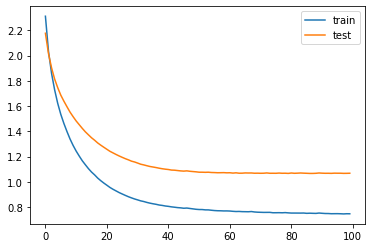

In [27]:
history = model_supervised.fit(train_X_super, train_y, epochs=100, batch_size=16, 
                    validation_data=(test_X_super, test_y), verbose=0, shuffle=True)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

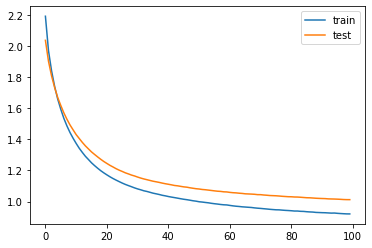

In [28]:
history = model_sequential.fit(train_X_seq, train_y, epochs=100, batch_size=16, 
                    validation_data=(test_X_seq, test_y), verbose=0, shuffle=True)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Evaluate models

- Evaluation doesn't work for `STEPS_OUT > 1`  
- Naive predictor doesn't work for `STEPS_OUT > 1`

But, both issues can be easily fixed (if needed).

In [29]:
train_inv_y = scaler.inverse_transform(train_y, **sparams)
test_inv_y = scaler.inverse_transform(test_y, **sparams)

### Naive predictions

In [30]:
naive_sup = naive_predictor('sup', len(dataset.columns), STEPS_IN, STEPS_OUT)
naive_seq = naive_predictor('seq', len(dataset.columns), STEPS_IN, STEPS_OUT)

In [31]:
train_ynaive_super = naive_sup.predict(train_X_super)
test_ynaive_super = naive_sup.predict(test_X_super)
train_inv_ynaive_super = scaler.inverse_transform(train_ynaive_super, **sparams)
test_inv_ynaive_super = scaler.inverse_transform(test_ynaive_super, **sparams)

In [32]:
train_ynaive_seq = naive_seq.predict(train_X_seq)
test_ynaive_seq = naive_seq.predict(test_X_seq)
train_inv_ynaive_seq = scaler.inverse_transform(train_ynaive_seq, **sparams)
test_inv_ynaive_seq = scaler.inverse_transform(test_ynaive_seq, **sparams)

### Models' predictions

In [33]:
train_yhat_super = model_supervised.predict(train_X_super)
test_yhat_super = model_supervised.predict(test_X_super)
train_inv_yhat_super = scaler.inverse_transform(train_yhat_super, **sparams)
test_inv_yhat_super = scaler.inverse_transform(test_yhat_super, **sparams)

In [34]:
train_yhat_seq = model_sequential.predict(train_X_seq)
test_yhat_seq = model_sequential.predict(test_X_seq)
train_inv_yhat_seq = scaler.inverse_transform(train_yhat_seq, **sparams)
test_inv_yhat_seq = scaler.inverse_transform(test_yhat_seq, **sparams)

In [35]:
scores_train_naive_super = calculate_measures(train_inv_y, train_inv_ynaive_super)
scores_test_naive_super = calculate_measures(test_inv_y, test_inv_ynaive_super)
scores_train_naive_seq = calculate_measures(train_inv_y, train_inv_ynaive_seq)
scores_test_naive_seq = calculate_measures(test_inv_y, test_inv_ynaive_seq)

/home/MCB/pszczerbiak/miniconda3/envs/keras/lib/python3.9/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.57623122084922 and the largest is 10.730617437088428.
  warn(
/home/MCB/pszczerbiak/miniconda3/envs/keras/lib/python3.9/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for 

In [36]:
scores_train_super = calculate_measures(train_inv_y, train_inv_yhat_super)
scores_test_super = calculate_measures(test_inv_y, test_inv_yhat_super)
scores_train_seq = calculate_measures(train_inv_y, train_inv_yhat_seq)
scores_test_seq = calculate_measures(test_inv_y, test_inv_yhat_seq)

/home/MCB/pszczerbiak/miniconda3/envs/keras/lib/python3.9/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.57623122084922 and the largest is 10.730617437088428.
  warn(
/home/MCB/pszczerbiak/miniconda3/envs/keras/lib/python3.9/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for 

In [37]:
"Super, train:", scores_train_super, "Super, train (naive):", scores_train_naive_super

('Super, train:',
 {'f1score': (1.0, 0.0),
  'spearman': (0.45987428181730144, 0.26469708368994094, 2),
  'nrmse': (0.10465419088535305, 0.04192464113652053, 2),
  'inter': (0.15918552347693055, 0.0899787080809725),
  'intra': 0.4921581552577902},
 'Super, train (naive):',
 {'f1score': (1.0, 0.0),
  'spearman': (0.40078147219264837, 0.22259844148375804, 3),
  'nrmse': (0.1269500304260625, 0.0494622396663146, 1),
  'inter': (0.22601373192842908, 0.14279732516658358),
  'intra': 0.6739000671292692})

In [38]:
"Super, test:", scores_test_super, "Super, test (naive):", scores_test_naive_super

('Super, test:',
 {'f1score': (1.0, 0.0),
  'spearman': (0.2945202226997668, 0.19257511285207007, 22),
  'nrmse': (0.24209226055970479, 0.2702383987062806, 22),
  'inter': (0.30468205166197104, 0.10749281770613744),
  'intra': 0.6880242059576458},
 'Super, test (naive):',
 {'f1score': (1.0, 0.0),
  'spearman': (0.39121476637603114, 0.2315491356369037, 25),
  'nrmse': (0.2840716412853171, 1.0559265182442188, 5),
  'inter': (0.24263612583725505, 0.15067398620962744),
  'intra': 0.6287646839282455})

In [39]:
"Seq, train:", scores_train_seq, "Seq, train (naive):", scores_train_naive_seq

('Seq, train:',
 {'f1score': (1.0, 0.0),
  'spearman': (0.3838123162140067, 0.24123000435476594, 2),
  'nrmse': (0.11289670193891518, 0.04000571617396018, 2),
  'inter': (0.19947668721853792, 0.09332144018492297),
  'intra': 0.597720259361371},
 'Seq, train (naive):',
 {'f1score': (1.0, 0.0),
  'spearman': (0.40078147219264837, 0.22259844148375804, 3),
  'nrmse': (0.1269500304260625, 0.0494622396663146, 1),
  'inter': (0.22601373192842908, 0.14279732516658358),
  'intra': 0.6739000671292692})

In [40]:
"Seq, test:", scores_test_seq, "Seq, test (naive):", scores_test_naive_seq

('Seq, test:',
 {'f1score': (1.0, 0.0),
  'spearman': (0.3058457365683271, 0.20200382468997372, 22),
  'nrmse': (0.1737003268264058, 0.04636077109748991, 22),
  'inter': (0.2486569648718374, 0.0818689071179154),
  'intra': 0.6266538624740501},
 'Seq, test (naive):',
 {'f1score': (1.0, 0.0),
  'spearman': (0.39121476637603114, 0.2315491356369037, 25),
  'nrmse': (0.2840716412853171, 1.0559265182442188, 5),
  'inter': (0.24263612583725505, 0.15067398620962744),
  'intra': 0.6287646839282455})

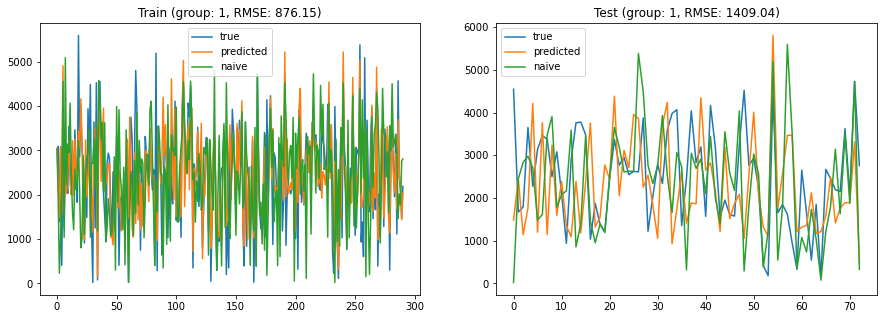

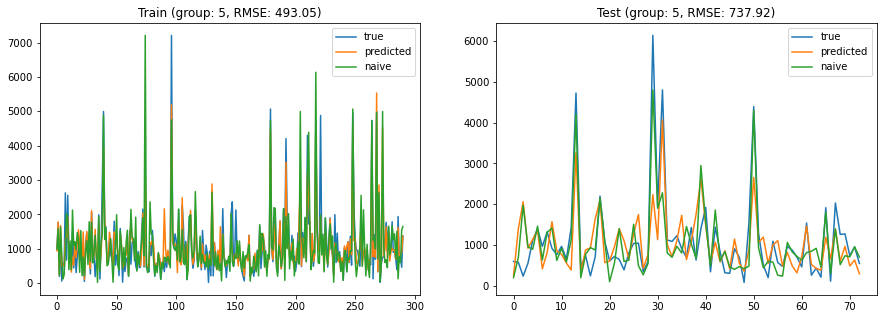

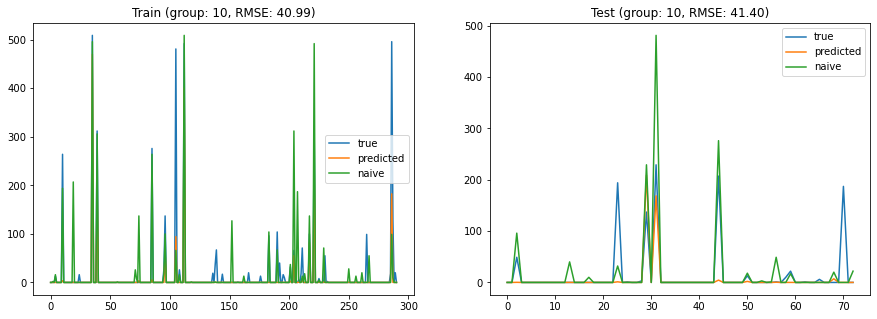

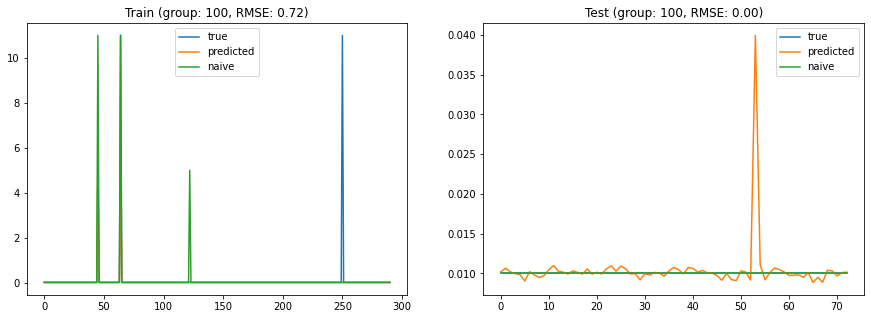

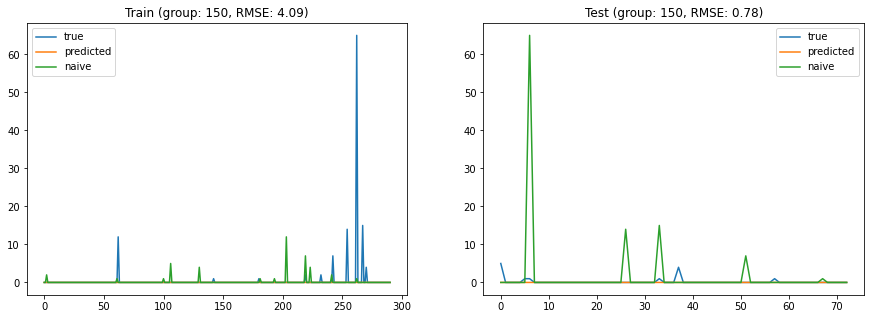

In [41]:
for group in [1, 5, 10, 100, 150]:
    plot_series(train_inv_y, train_inv_yhat_super, train_inv_ynaive_super, 
                test_inv_y, test_inv_yhat_super, test_inv_ynaive_super, group)

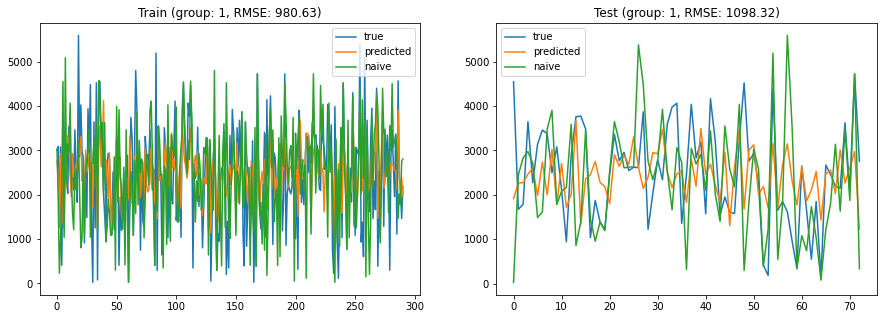

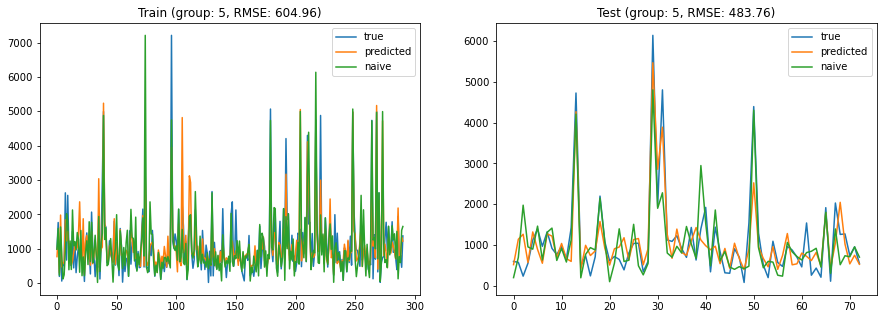

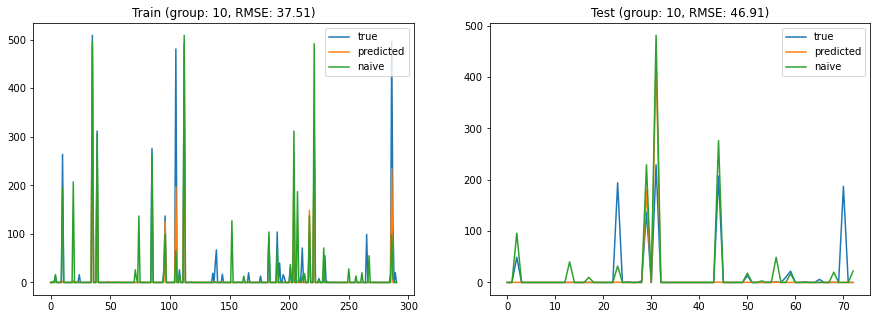

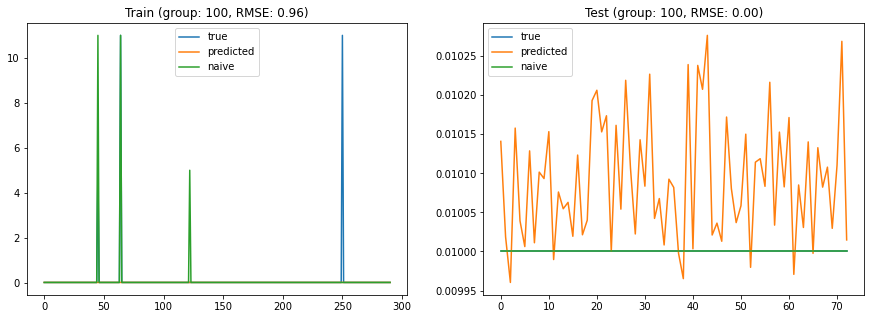

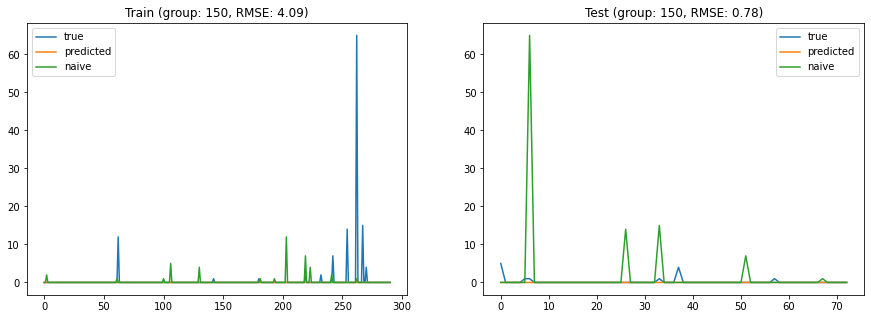

In [42]:
for group in [1, 5, 10, 100, 150]:
    plot_series(train_inv_y, train_inv_yhat_seq, train_inv_ynaive_seq, 
                test_inv_y, test_inv_yhat_seq, test_inv_ynaive_seq, group)

## Test on reference dataset

In [43]:
ref_dataset =  pd.DataFrame(scaler.transform(ref_dataset_original), 
                            columns=ref_dataset_original.columns, 
                            index=ref_dataset_original.index)
ref_reframed = series_to_supervised(ref_dataset.values, STEPS_IN, STEPS_OUT)

In [44]:
ref_X, ref_y, _, _ = split_reframed(ref_reframed, len(ref_dataset.columns), 1, STEPS_IN,
                                    overlap=True, shuffle=True)

In [45]:
ref_X_seq, _ = prepare_sequential_data(ref_X, None, in_features)
ref_X_super, _ = prepare_supervised_data(ref_X)

In [46]:
ref_yhat_super = model_supervised.predict(ref_X_super)
ref_yhat_seq = model_sequential.predict(ref_X_seq)

In [47]:
ref_inv_y = scaler.inverse_transform(ref_y, **sparams)
ref_inv_yhat_super = scaler.inverse_transform(ref_yhat_super, **sparams)
ref_inv_yhat_seq = scaler.inverse_transform(ref_yhat_seq, **sparams)

In [48]:
scores_ref_super = calculate_measures(ref_inv_y, ref_inv_yhat_super)
scores_ref_seq = calculate_measures(ref_inv_y, ref_inv_yhat_seq)

/home/MCB/pszczerbiak/miniconda3/envs/keras/lib/python3.9/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.414926149478648 and the largest is 11.784513184162961.
  warn(
/home/MCB/pszczerbiak/miniconda3/envs/keras/lib/python3.9/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for

In [49]:
"Super, ref:", scores_ref_super

('Super, ref:',
 {'f1score': (1.0, 0.0),
  'spearman': (0.29713729025782404, 0.2633636080116751, 0),
  'nrmse': (0.36467690386444823, 1.1658736927572388, 0),
  'inter': (0.5105850266646591, 0.14378591867054763),
  'intra': 0.6035550213354197})

In [50]:
"Seq, ref:", scores_ref_seq

('Seq, ref:',
 {'f1score': (1.0, 0.0),
  'spearman': (0.29456905482285595, 0.26606114335244313, 0),
  'nrmse': (0.16614723384309005, 0.24758491724905413, 0),
  'inter': (0.4148150063457986, 0.10842554828664192),
  'intra': 0.5899620878977415})

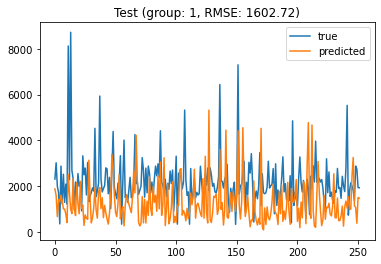

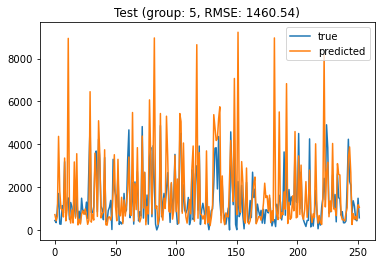

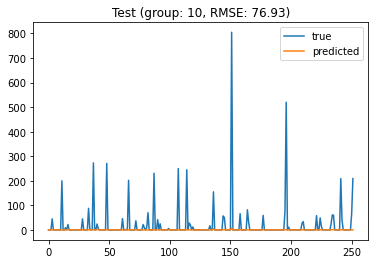

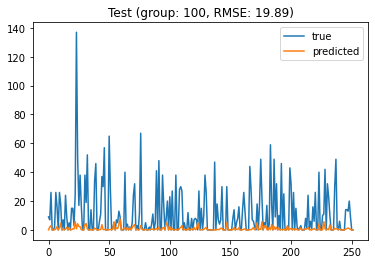

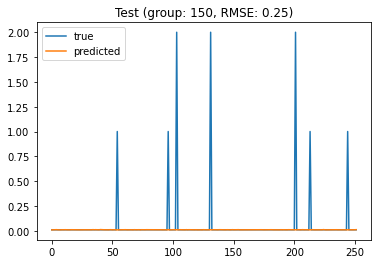

In [51]:
for group in [1, 5, 10, 100, 150]:
    plot_series(None, None, None, ref_inv_y, ref_inv_yhat_super, None, group)

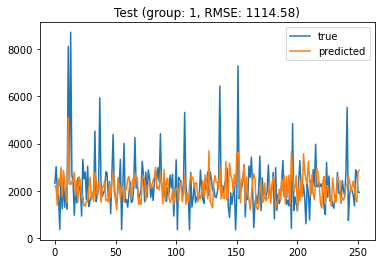

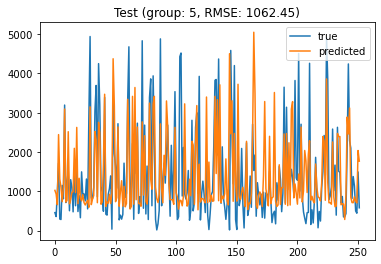

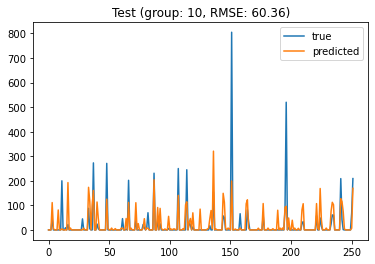

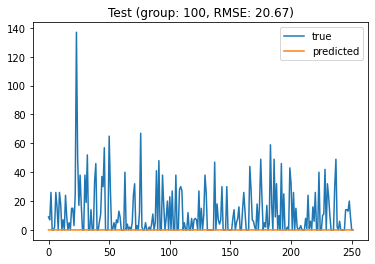

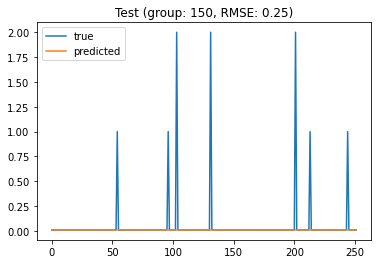

In [52]:
for group in [1, 5, 10, 100, 150]:
    plot_series(None, None, None, ref_inv_y, ref_inv_yhat_seq, None, group)